# Attack rates of simple model
Starting by looking at the distribution of attack rates for the simple model


In [300]:
from jupyter_core.application import base_flags
from sympy.matrices.expressions.matmul import combine_one_matrices
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [301]:
from day_and_night.model import simulate, two_way_r0, one_way_to_two_way, two_way_to_one_way
from grab_data import *
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300


In [302]:
DATASET = 'CENSUS_SUBSAMPLED'
MODEL = 'random'
flow_matrix = get_matrix(DATASET)
population_sizes = get_population_sizes(DATASET)
total_pop = population_sizes.sum()
population_names = get_population_ordering(DATASET)

In [303]:
base_one_way_params = dict(gamma=0.45, psi=0.6, od_matrix=flow_matrix, pop_sizes=population_sizes, )


def final_size_dist(param, k=30, model='perfect', allow_extinction=False):
    samples = np.zeros(shape=(k, flow_matrix.shape[0]))
    for j in range(k):
        s, i, _, _ = simulate(**param, od_matrix=flow_matrix,
                              pop_sizes=population_sizes, model=model)
        if not allow_extinction:
            while i.sum(axis=(0, 1, 2)) / total_pop < 0.01:
                s, i, _, _ = simulate(**param, od_matrix=flow_matrix, pop_sizes=population_sizes, model=model)
        samples[j, :] = 1 - s[-1, ...].sum(axis=1) / population_sizes
    return samples.T

In [304]:
def count_extinction_events(param, k=30, model='perfect'):
    extinction_events = 0
    for j in range(k):
        s, i, _, _ = simulate(**param, od_matrix=flow_matrix,
                              pop_sizes=population_sizes, model=model)
        if i.sum(axis=(0, 1, 2)) / total_pop < 0.01:
            extinction_events += 1
    return extinction_events

In [305]:
n_samples = 30
one_way_betas = np.linspace(1, 3, 5)
two_way_params = []
one_way_params = []
r0s = []
for beta in one_way_betas:
    two_way = one_way_to_two_way(**base_one_way_params, beta=beta)
    one_way = dict(beta=beta, gamma=base_one_way_params['gamma'], psi=base_one_way_params['psi'])
    two_r0 = np.round(two_way_r0(**two_way, od_matrix=flow_matrix, pop_sizes=population_sizes), 2)
    r0s.append(two_r0)
    two_way_params.append(two_way)
    one_way_params.append(one_way)
colors = ['r', 'g', 'b', 'c', 'y']

In [306]:
final_size_dists = dict(perfect=[], random=[], random_oneway=[], perfect_oneway=[])
params = dict(perfect=two_way_params, random=two_way_params, random_oneway=one_way_params,
             perfect_oneway=one_way_params)
for index in range(len(two_way_params)):
    for key in list(final_size_dists.keys()):
        final_size_dists[key].append(
            final_size_dist(param=params[key][index], k=n_samples, model=key, allow_extinction=False))


KeyboardInterrupt: 

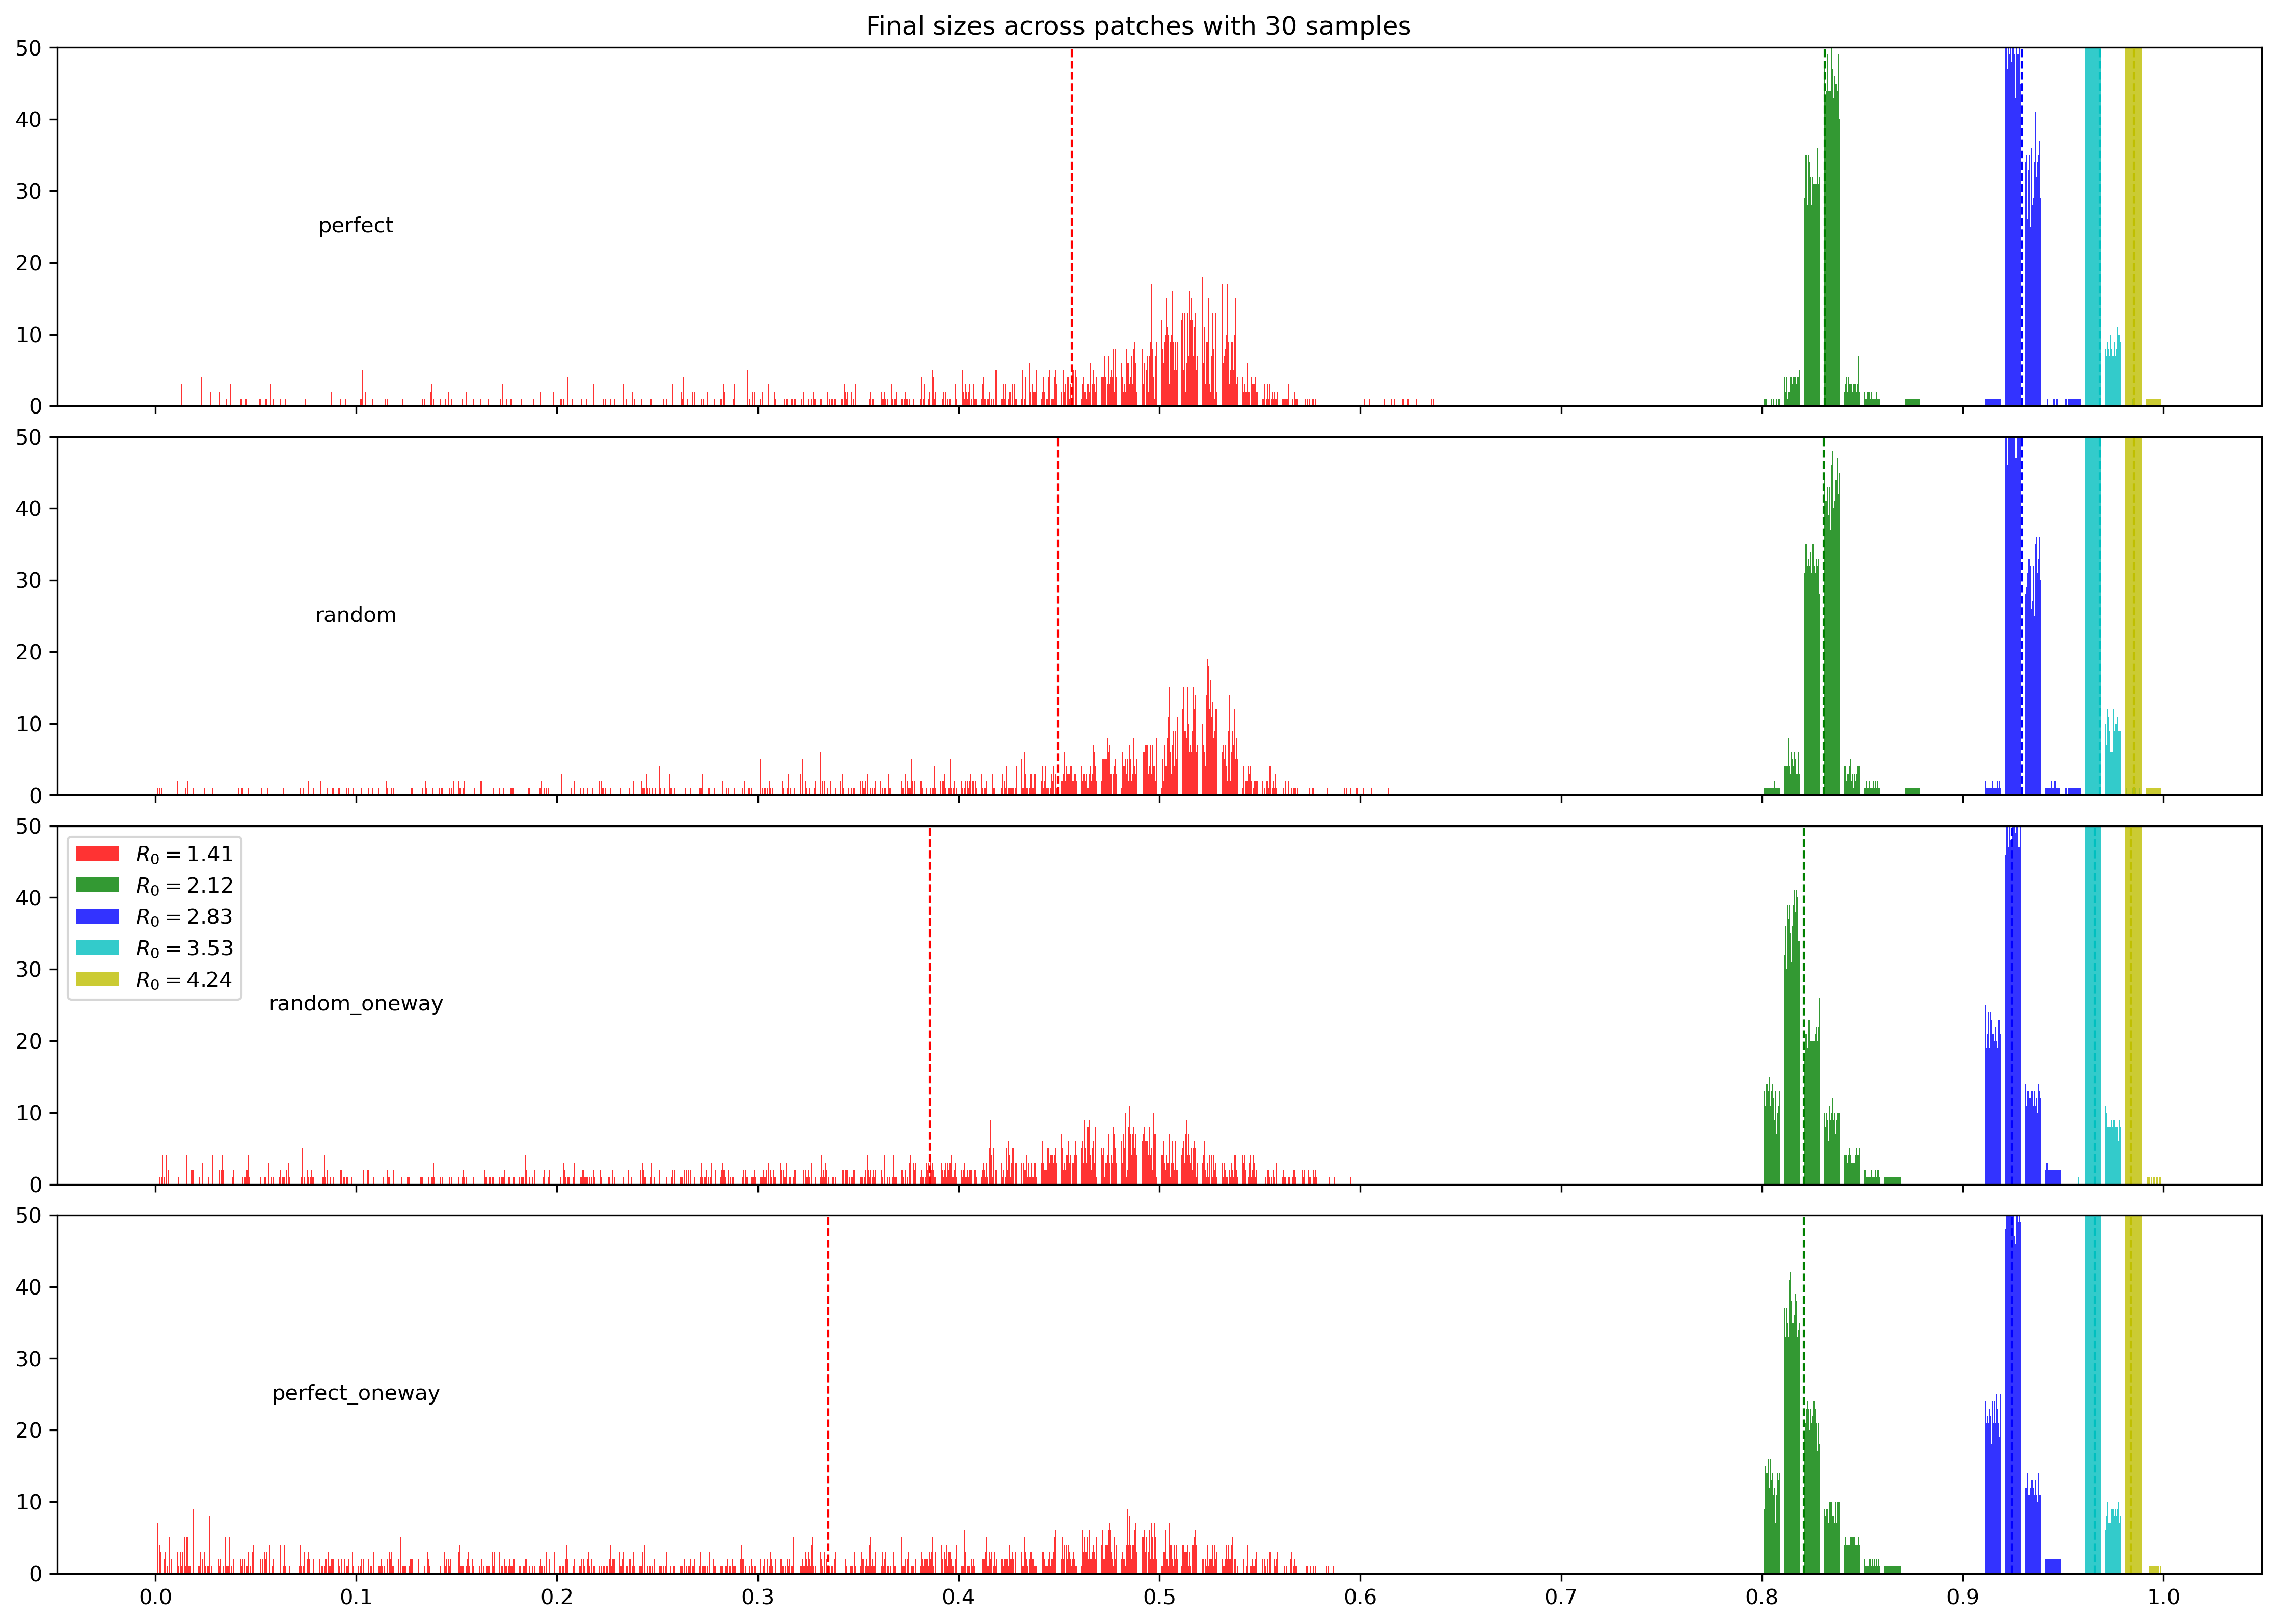

In [291]:
common_params = dict(bins=100, alpha=0.8, range=(0, 1))
models = list(final_size_dists.keys())
fig, axes = plt.subplots(ncols=1, nrows=len(final_size_dists), sharex=True, figsize=(15, 15))
plt.subplots_adjust(hspace=.5)

for index, ax in enumerate(axes):
    model = models[index]
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.text(0.1, 25, model, horizontalalignment='center', verticalalignment='center')
    ax.set_ylim(0, 50)
    for k, dist in enumerate(final_size_dists[model]):
        ax.hist(dist, color=[colors[k] for _ in range(n_samples)], label=f'$R_0 = {r0s[k]}$',
                **common_params)
        ax.axvline(np.mean(dist, axis=(0, 1)), color=colors[k], linestyle='dashed', linewidth=1)
    if index == 2:
        ax.legend(loc='best')
fig.suptitle(f'Final sizes across patches with {n_samples} samples')
fig.tight_layout()
fig.subplots_adjust(bottom=0.3, wspace=0.33)
plt.show()

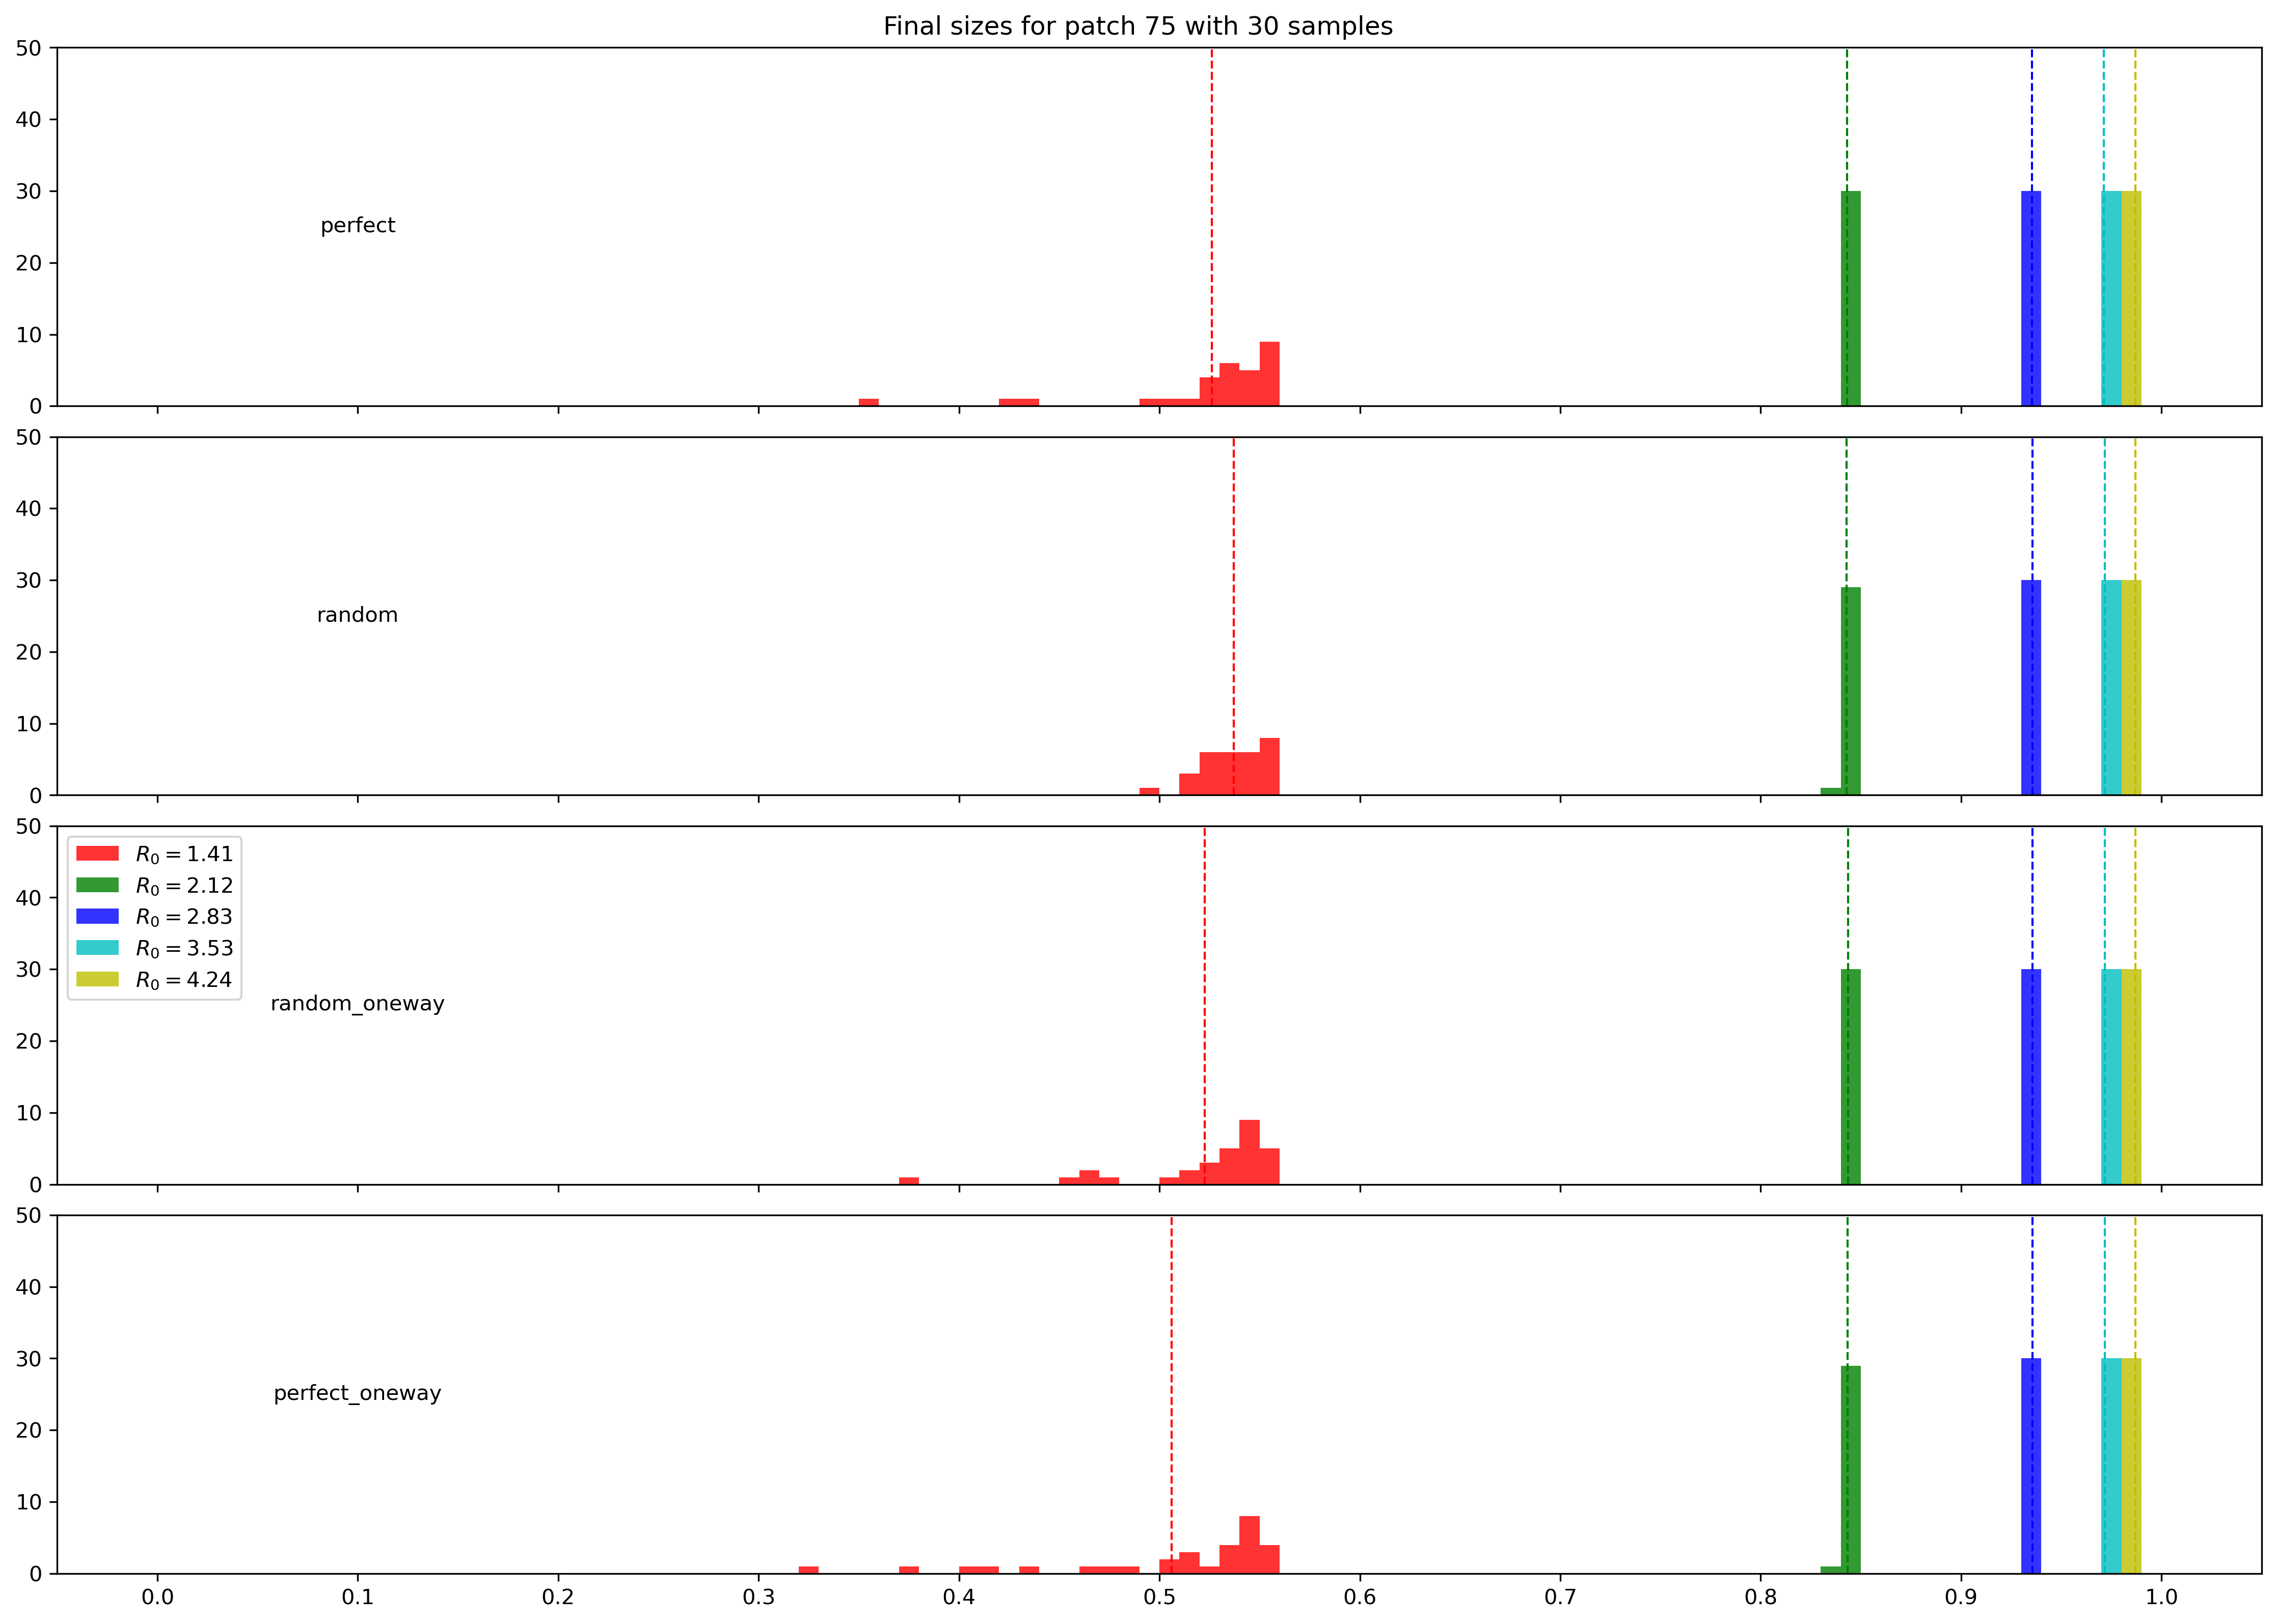

In [299]:
patch = 75
fig, axes = plt.subplots(ncols=1, nrows=len(final_size_dists), sharex=True,figsize=(15, 15))
plt.subplots_adjust(hspace=.5)

for index, ax in enumerate(axes):
    model = models[index]
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.text(0.1, 25, model, horizontalalignment='center', verticalalignment='center')
    ax.set_ylim(0, 50)
    for k, dist in enumerate(final_size_dists[model]):
        ax.hist(dist[patch, :], color=colors[k], label=f'$R_0 = {r0s[k]}$',
                **common_params)
        ax.axvline(np.mean(dist[patch, :]), color=colors[k], linestyle='dashed', linewidth=1)
    if index == 2:
        ax.legend(loc='best')
fig.suptitle(f'Final sizes for patch {patch} with {n_samples} samples')
fig.tight_layout()
fig.subplots_adjust(bottom=0.3, wspace=0.33)
plt.show()
plt.show()